In [1]:
!pip install tensorflow

In [2]:
!pip install remotezip tqdm opencv-python
!pip install -q git+https://github.com/tensorflow/docs
!pip install ffmpeg-python
!pip install einops
!pip install matplotlib
!pip install seaborn
!pip install keras

In [3]:
!pip install pydot-ng

In [4]:
!pip install scikit-learn

In [1]:
import tensorflow as tf
from tensorflow import keras
from sklearn import preprocessing as pp

import tqdm
import random
import pathlib
import itertools
import collections

import os
import cv2
import einops
import numpy as np
import remotezip as rz
import joblib

# Some modules to display an animation using imageio.
import imageio
from IPython import display
from urllib import request
from tensorflow_docs.vis import embed
from zipfile import ZipFile
from keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
URL = "./FightDataset.zip"

In [3]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a URL with the zip file.

    Args:
      zip_url: A URL from which the files can be extracted from.

    Returns:
      List of files in each of the classes.
  """
  files = []
  with zip_url as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [4]:
def list_files_from_zip_url(zip_url):
  """ List the files in each class of the dataset given a directory with the zip file

    Args:
        zip_url: A path from which files can be extracted.

    Return:
      List of files in each of the classes 
  """
  files = []
  with ZipFile(zip_url, 'r') as zip:
    for zip_info in zip.infolist():
      files.append(zip_info.filename)
  return files

In [5]:
files = list_files_from_zip_url(URL)
files = [f for f in files if f.endswith('.mp4')]
files[:10]

['fight/fi001.mp4',
 'fight/fi002.mp4',
 'fight/fi003.mp4',
 'fight/fi004.mp4',
 'fight/fi005.mp4',
 'fight/fi006.mp4',
 'fight/fi007.mp4',
 'fight/fi008.mp4',
 'fight/fi009.mp4',
 'fight/fi010.mp4']

In [6]:
def get_class(fname):
  """ Retrieve the name of the class given a filename.

    Args:
      fname: Name of the file in the UCF101 dataset.

    Returns:
      Class that the file belongs to.
  """
  # print(fname)
  return fname.split('/', 1)[0]

In [7]:
def get_files_per_class(files):
  """ Retrieve the files that belong to each class.

    Args:
      files: List of files in the dataset.

    Returns:
      Dictionary of class names (key) and files (values). 
  """
  files_for_class = collections.defaultdict(list)
  for fname in files:
    class_name = get_class(fname)
    files_for_class[class_name].append(fname)
  return files_for_class

In [8]:
NUM_CLASSES = 2
FILES_PER_CLASS = 150

In [9]:
files_for_class = get_files_per_class(files)
classes = list(files_for_class.keys())

print('Num classes:', len(classes))

for i in range(0, len(classes)):
  print(f"Num videos for class[{i}]:", len(files_for_class[classes[i]]))

Num classes: 2
Num videos for class[0]: 150
Num videos for class[1]: 150


Create a new function called select_subset_of_classes that selects a subset of the classes present within the dataset and a particular number of files per class:

In [10]:
def select_subset_of_classes(files_for_class, classes, files_per_class):
  """ Create a dictionary with the class name and a subset of the files in that class.

    Args:
      files_for_class: Dictionary of class names (key) and files (values).
      classes: List of classes.
      files_per_class: Number of files per class of interest.

    Returns:
      Dictionary with class as key and list of specified number of video files in that class.
  """
  files_subset = dict()

  for class_name in classes:
    class_files = files_for_class[class_name]
    files_subset[class_name] = class_files[:files_per_class]

  return files_subset

In [11]:
files_subset = select_subset_of_classes(files_for_class, classes[:NUM_CLASSES], FILES_PER_CLASS)
list(files_subset.keys())

['fight', 'noFight']

In [12]:
def extract_from_zip(zip_url, to_dir, file_names):
  """ Extract the contents of the zip file from the path provided.

    Args:
      zip_url: A directory path with a zip file containing data.
      to_dir: A directory to download data to.
      file_names: Names of files to extract.
  """
  with ZipFile(zip_url, 'r') as zip:
    for fn in tqdm.tqdm(file_names):
      class_name = get_class(fn)
      zip.extract(fn, str(to_dir / class_name))
      unzipped_file = to_dir / class_name / fn

      fn = pathlib.Path(fn).parts[-1]
      output_file = to_dir / class_name / fn
      unzipped_file.rename(output_file)

In [13]:
def split_class_lists(files_for_class, count):
  """ Returns the list of files belonging to a subset of data as well as the remainder of
    files that need to be downloaded.
    
    Args:
      files_for_class: Files belonging to a particular class of data.
      count: Number of files to download.

    Returns:
      Files belonging to the subset of data and dictionary of the remainder of files that need to be downloaded.
  """
  split_files = []
  remainder = {}
  for cls in files_for_class:
    split_files.extend(files_for_class[cls][:count])
    remainder[cls] = files_for_class[cls][count:]
  return split_files, remainder

In [14]:
def download_ucf_101_subset(zip_url, num_classes, splits, download_dir):
  """ Extract the FightDataset and split them into various parts, such as training, validation, and test.

    Args:
      zip_url: A path with a ZIP file with the data.
      num_classes: Number of labels.
      splits: Dictionary specifying the training, validation, test, etc. (key) division of data
              (value is number of files per split).
      download_dir: Directory to download data to.

    Return:
      Mapping of the directories containing the subsections of data.
  """
  files = list_files_from_zip_url(zip_url)
  for f in files:
    path = os.path.normpath(f)
    tokens = path.split(os.sep)
  
  files_for_class = get_files_per_class(files)

  classes = list(files_for_class.keys())[:num_classes]

  for cls in classes:
    random.shuffle(files_for_class[cls])
    
  # Only use the number of classes you want in the dictionary
  files_for_class = {x: files_for_class[x] for x in classes}

  dirs = {}
  for split_name, split_count in splits.items():
    print(split_name, ":")
    split_dir = download_dir / split_name
    split_files, files_for_class = split_class_lists(files_for_class, split_count)
    extract_from_zip(zip_url, split_dir, split_files)
    dirs[split_name] = split_dir

  return dirs

In [15]:
download_dir = pathlib.Path('./Fight/')
subset_paths = download_ucf_101_subset(URL,
                                       num_classes = NUM_CLASSES,
                                       splits = {"train": 120, "val": 15, "test": 15},
                                       download_dir = download_dir)

train :


100%|███████████████████████████████████████████████████████████████████████████████| 240/240 [00:00<00:00, 597.13it/s]


val :


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 618.11it/s]


test :


100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 672.04it/s]


In [16]:
video_count_train = len(list(download_dir.glob('train/*/*.mp4')))
video_count_val = len(list(download_dir.glob('val/*/*.mp4')))
video_count_test = len(list(download_dir.glob('test/*/*.mp4')))
video_total = video_count_train + video_count_val + video_count_test
print(f"Total videos: {video_total}")

Total videos: 298


In [17]:
def format_frames(frame, output_size):
  """
    Pad and resize an image from a video.
    
    Args:
      frame: Image that needs to resized and padded. 
      output_size: Pixel size of the output frame image.

    Return:
      Formatted frame with padding of specified output size.
  """
  frame = tf.image.convert_image_dtype(frame, tf.float32)
  frame = tf.image.resize_with_pad(frame, *output_size)
  return frame

In [18]:
def frames_from_video_file(video_path, n_frames, output_size = (224,224), frame_step = 5):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  return result

**Visualize the data**

In [19]:
def to_gif(images):
  converted_images = np.clip(images * 255, 0, 255).astype(np.uint8)
  imageio.mimsave('./animation.gif', converted_images, fps=10)
  return embed.embed_file('./animation.gif')


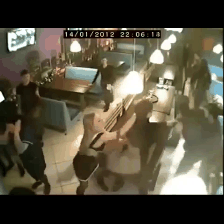

In [21]:
sample_video = frames_from_video_file(next(subset_paths['train'].glob('*/*.mp4')), 60)
to_gif(sample_video)

In [22]:
class FrameGenerator:
  def __init__(self, path, n_frames, training = False):
    """ Returns a set of frames with their associated label. 

      Args:
        path: Video file paths.
        n_frames: Number of frames. 
        training: Boolean to determine if training dataset is being created.
    """
    self.path = path
    self.n_frames = n_frames
    self.training = training
    self.class_names = sorted(set(p.name for p in self.path.iterdir() if p.is_dir()))
    self.class_ids_for_name = dict((name, idx) for idx, name in enumerate(self.class_names))

  def get_files_and_class_names(self):
    video_paths = list(self.path.glob('*/*.mp4'))
    classes = [p.parent.name for p in video_paths] 
    return video_paths, classes

  def __call__(self):
    video_paths, classes = self.get_files_and_class_names()

    pairs = list(zip(video_paths, classes))

    if self.training:
      random.shuffle(pairs)

    for path, name in pairs:
      video_frames = frames_from_video_file(path, self.n_frames) 
      label = self.class_ids_for_name[name] # Encode labels
      yield video_frames, label

In [23]:
fg = FrameGenerator(subset_paths['train'], 10, training=True)

frames, label = next(fg())

print(f"Type of input: {subset_paths['train']}")
print(type(fg))
print(f"Shape: {frames.shape}")
print(f"Label: {label}")

Type of input: Fight\train
<class '__main__.FrameGenerator'>
Shape: (10, 224, 224, 3)
Label: 0


In [24]:
n_frames = 10
batch_size = 8

output_signature = (tf.TensorSpec(shape = (None, None, None, 3), dtype = tf.float32),
                    tf.TensorSpec(shape = (), dtype = tf.int16))

train_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['train'], n_frames, training=True),
                                          output_signature = output_signature)


# Batch the data
train_ds = train_ds.batch(batch_size).repeat(3)

val_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['val'], n_frames),
                                        output_signature = output_signature)
val_ds = val_ds.batch(batch_size).repeat(3)

test_ds = tf.data.Dataset.from_generator(FrameGenerator(subset_paths['test'], n_frames),
                                         output_signature = output_signature)

test_ds = test_ds.batch(batch_size).repeat(3)

In [25]:
# Define the dimensions of one frame in the set of frames created
HEIGHT = 224
WIDTH = 224

In [26]:
class Conv2Plus1D(keras.layers.Layer):
  def __init__(self, filters, kernel_size, padding):
    """
      A sequence of convolutional layers that first apply the convolution operation over the
      spatial dimensions, and then the temporal dimension. 
    """
    super().__init__()
    self.seq = keras.Sequential([  
        # Spatial decomposition
        layers.Conv3D(filters=filters,
                      kernel_size=(1, kernel_size[1], kernel_size[2]),
                      padding=padding),
        # Temporal decomposition
        layers.Conv3D(filters=filters, 
                      kernel_size=(kernel_size[0], 1, 1),
                      padding=padding)
        ])

  def get_config(self):
    config = super().get_config()
    #Update the config with the custom layer's parameters
    from tensorflow.keras.utils import get_custom_objects, register_keras_serializable
    get_custom_objects().update({ "Conv2Plus1D": Conv2Plus1D })
    register_keras_serializable(package= "MyLayers", name="Conv2Plus1D")(Conv2Plus1D)
      
    return config
    
  def call(self, x):
    return self.seq(x)

In [27]:
class ResidualMain(keras.layers.Layer):
  """
    Residual block of the model with convolution, layer normalization, and the
    activation function, ReLU.
  """
  def __init__(self, filters, kernel_size):
    super().__init__()
    self.seq = keras.Sequential([
        Conv2Plus1D(filters=filters,
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization(),
        layers.ReLU(),
        Conv2Plus1D(filters=filters, 
                    kernel_size=kernel_size,
                    padding='same'),
        layers.LayerNormalization()
    ])

  def get_config(self):
    config = super().get_config()
    #Update the config with the custom layer's parameters
    from tensorflow.keras.utils import get_custom_objects, register_keras_serializable
    get_custom_objects().update({ "ResidualMain": ResidualMain })
    register_keras_serializable(package = "MyLayers", name = "ResidualMain")(ResidualMain)
      
    return config
    
  def call(self, x):
    return self.seq(x)

In [28]:
class Project(keras.layers.Layer):
  """
    Project certain dimensions of the tensor as the data is passed through different 
    sized filters and downsampled. 
  """
  def __init__(self, units):
    super().__init__()
    self.seq = keras.Sequential([
        layers.Dense(units),
        layers.LayerNormalization()
    ])

  def get_config(self):
    config = super().get_config()
    from tensorflow.keras.utils import get_custom_objects, register_keras_serializable
    get_custom_objects().update({ "Project": Project })
    register_keras_serializable(package = "MyLayers", name = "Project")(Project)
    return config
    
  def call(self, x):
    return self.seq(x)

In [29]:
def add_residual_block(input, filters, kernel_size):
  """
    Add residual blocks to the model. If the last dimensions of the input data
    and filter size does not match, project it such that last dimension matches.
  """
  out = ResidualMain(filters, 
                     kernel_size)(input)
  
  res = input
  # Using the Keras functional APIs, project the last dimension of the tensor to
  # match the new filter size
  if out.shape[-1] != input.shape[-1]:
    res = Project(out.shape[-1])(res)

  return layers.add([res, out])

In [30]:
class ResizeVideo(keras.layers.Layer):
  def __init__(self, height, width):
    super().__init__()
    self.height = height
    self.width = width
    self.resizing_layer = layers.Resizing(self.height, self.width)

  def get_config(self):
    config = super().get_config()
    from tensorflow.keras.utils import get_custom_objects, register_keras_serializable
    get_custom_objects().update({ "ResizeVideo": ResizeVideo })
    register_keras_serializable(package = "MyLayers", name = "ResizeVideo")(ResizeVideo)
    return config

  def call(self, video):
    """
      Use the einops library to resize the tensor.  
      
      Args:
        video: Tensor representation of the video, in the form of a set of frames.
      
      Return:
        A downsampled size of the video according to the new height and width it should be resized to.
    """
    # b stands for batch size, t stands for time, h stands for height, 
    # w stands for width, and c stands for the number of channels.
    old_shape = einops.parse_shape(video, 'b t h w c')
    images = einops.rearrange(video, 'b t h w c -> (b t) h w c')
    images = self.resizing_layer(images)
    videos = einops.rearrange(
        images, '(b t) h w c -> b t h w c',
        t = old_shape['t'])
    return videos

In [31]:
input_shape = (None, 10, HEIGHT, WIDTH, 3)
input = layers.Input(shape=(input_shape[1:]))
x = input

conv = Conv2Plus1D(filters=16, kernel_size=(3, 7, 7), padding='same')(x)
batched = layers.BatchNormalization()(conv)
relu_layer = layers.ReLU()(batched)
resized = ResizeVideo(HEIGHT // 2, WIDTH // 2)(relu_layer)

# Block 1
block1_res = add_residual_block(resized, 16, (3, 3, 3))
resized1 = ResizeVideo(HEIGHT // 4, WIDTH // 4)(block1_res)

# Block 2
block2_res = add_residual_block(resized1, 32, (3, 3, 3))
resized2 = ResizeVideo(HEIGHT // 8, WIDTH // 8)(block2_res)

# Block 3
block3_res = add_residual_block(resized2, 64, (3, 3, 3))
resized3 = ResizeVideo(HEIGHT // 16, WIDTH // 16)(block3_res)

# Block 4
block4_res = add_residual_block(resized3, 128, (3, 3, 3))

pooled = layers.GlobalAveragePooling3D()(block4_res)
flat = layers.Flatten()(pooled)
output = layers.Dense(2)(flat)

model = keras.Model(input, output)

In [32]:
frames, label = next(iter(train_ds))
model.build(frames)

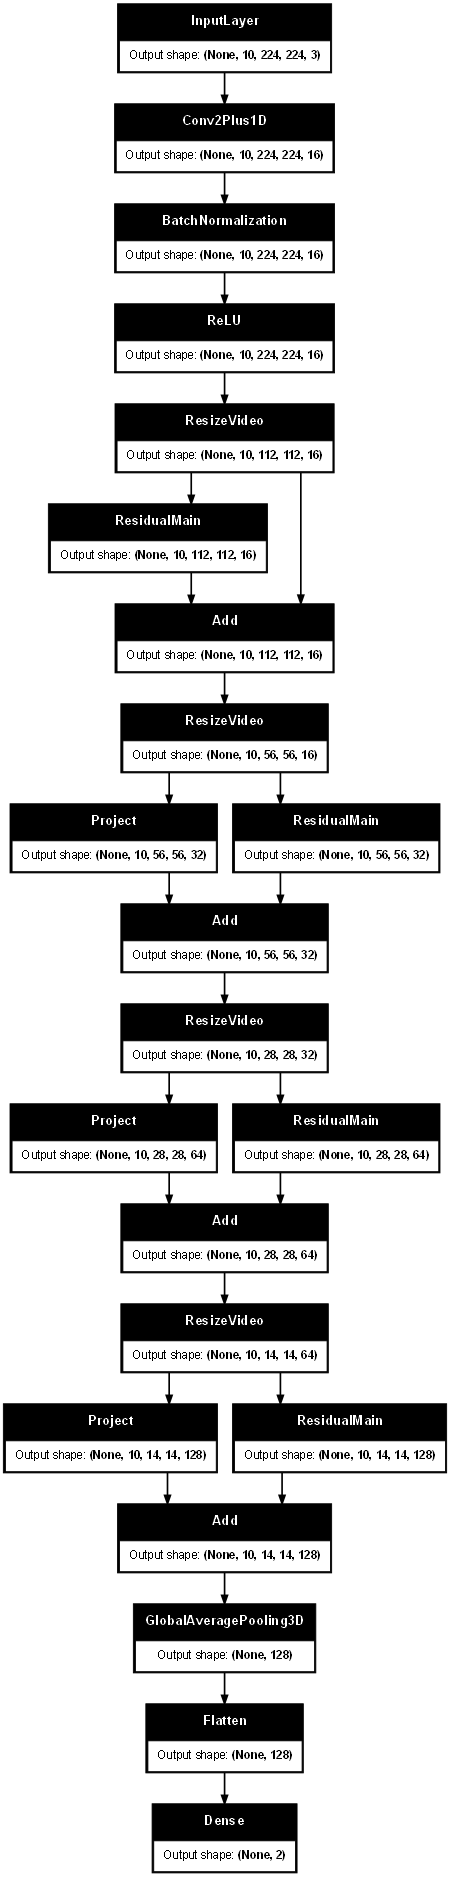

In [33]:
# Visualize the model
keras.utils.plot_model(model, expand_nested=True, dpi=60, show_shapes=True)

In [34]:
model.compile(loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True), 
              optimizer = keras.optimizers.Adam(learning_rate = 0.0001), 
              metrics = ['accuracy'])

In [35]:
history = model.fit(x = train_ds,
                    epochs = 1, 
                    validation_data = val_ds)

     90/Unknown 146s 2s/step - accuracy: 0.5476 - loss: 0.8202

C:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


90/90 ━━━━━━━━━━━━━━━━━━━━ 157s 2s/step - accuracy: 0.5479 - loss: 0.8193 - val_accuracy: 0.5000 - val_loss: 0.7067


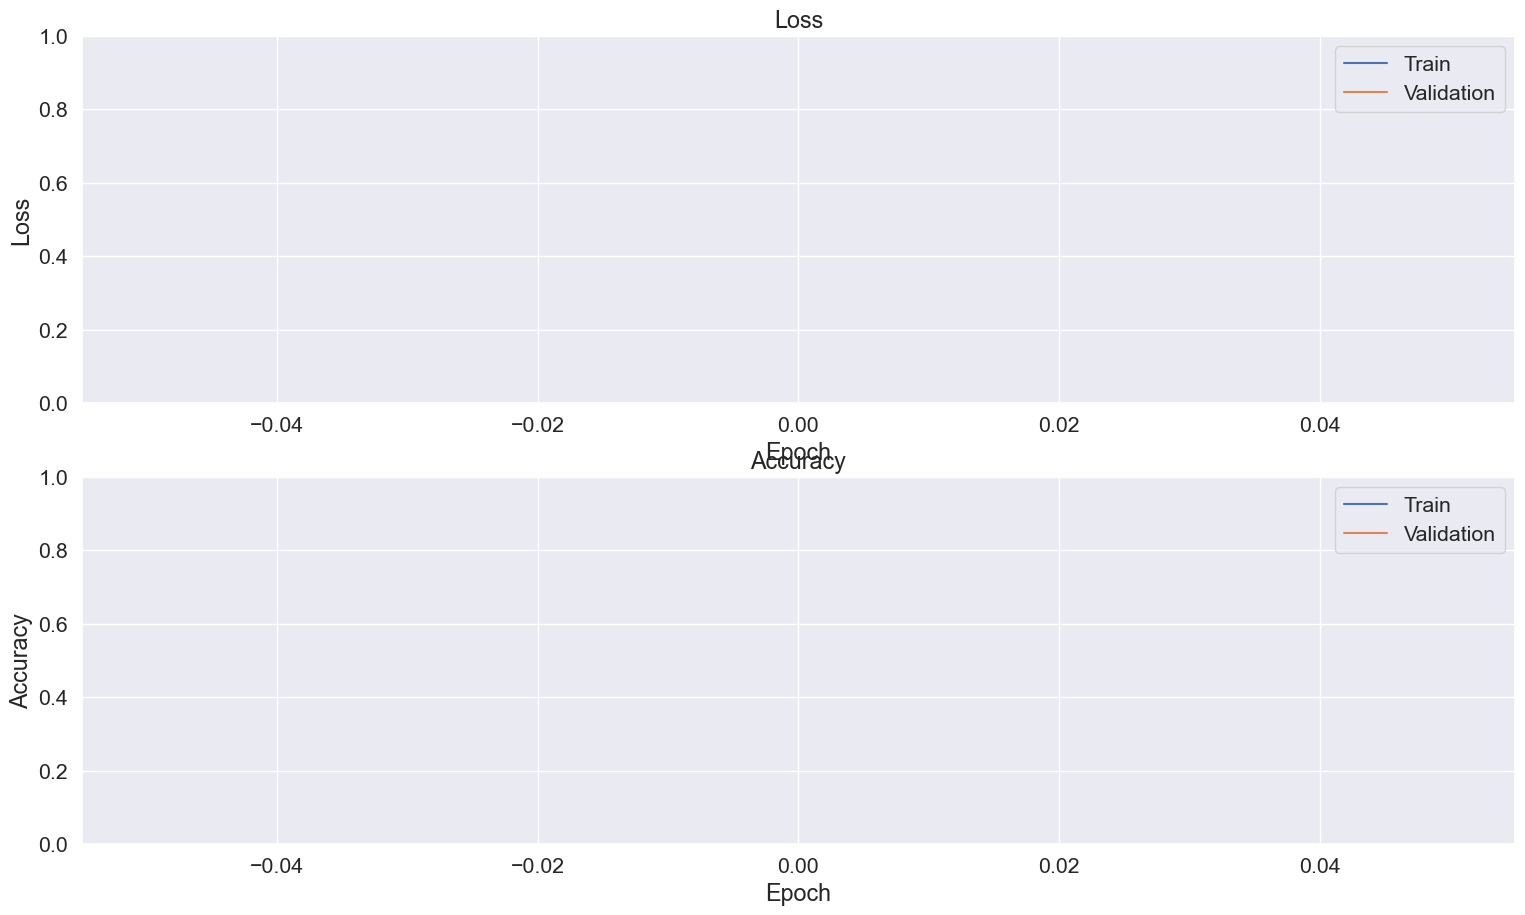

In [83]:
def plot_history(history):
  """
    Plotting training and validation learning curves.

    Args:
      history: model history with all the metric measures
  """
  fig, (ax1, ax2) = plt.subplots(2)

  fig.set_size_inches(18.5, 10.5)

  # Plot loss
  ax1.set_title('Loss')
  ax1.plot(history.history['loss'], label = 'train')
  ax1.plot(history.history['val_loss'], label = 'test')
  ax1.set_ylabel('Loss')
  
  # Determine upper bound of y-axis
  max_loss = max(history.history['loss'] + history.history['val_loss'])

  ax1.set_ylim([0, np.ceil(max_loss)])
  ax1.set_xlabel('Epoch')
  ax1.legend(['Train', 'Validation']) 

  # Plot accuracy
  ax2.set_title('Accuracy')
  ax2.plot(history.history['accuracy'],  label = 'train')
  ax2.plot(history.history['val_accuracy'], label = 'test')
  ax2.set_ylabel('Accuracy')
  ax2.set_ylim([0, 1])
  ax2.set_xlabel('Epoch')
  ax2.legend(['Train', 'Validation'])

  plt.show()

plot_history(history)

In [84]:
model.evaluate(test_ds, return_dict=True)

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 798ms/step - accuracy: 0.6484 - loss: 0.6252


{'accuracy': 0.5666666626930237, 'loss': 0.6230542063713074}

In [85]:
def get_actual_predicted_labels(dataset): 
  """
    Create a list of actual ground truth values and the predictions from the model.

    Args:
      dataset: An iterable data structure, such as a TensorFlow Dataset, with features and labels.

    Return:
      Ground truth and predicted values for a particular dataset.
  """
  actual = [labels for _, labels in dataset.unbatch()]
  predicted = model.predict(dataset)

  actual = tf.stack(actual, axis=0)
  predicted = tf.concat(predicted, axis=0)
  predicted = tf.argmax(predicted, axis=1)

  return actual, predicted

In [86]:
def plot_confusion_matrix(actual, predicted, labels, ds_type):
  cm = tf.math.confusion_matrix(actual, predicted)
  ax = sns.heatmap(cm, annot=True, fmt='g')
  sns.set(rc={'figure.figsize':(12, 12)})
  sns.set(font_scale=1.4)
  ax.set_title('Confusion matrix of action recognition for ' + ds_type)
  ax.set_xlabel('Predicted Action')
  ax.set_ylabel('Actual Action')
  plt.xticks(rotation=90)
  plt.yticks(rotation=0)
  ax.xaxis.set_ticklabels(labels)

90/90 ━━━━━━━━━━━━━━━━━━━━ 78s 857ms/step


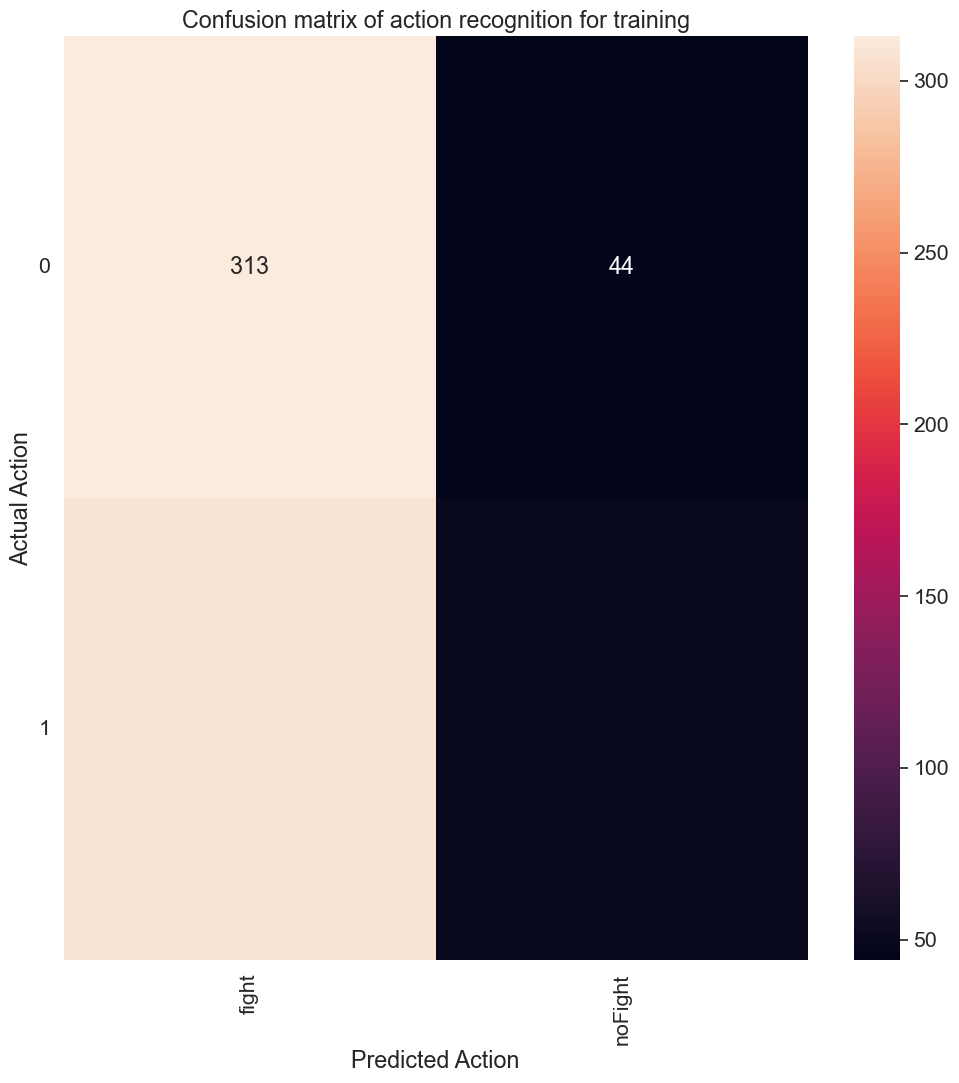

In [87]:
fg = FrameGenerator(subset_paths['train'], n_frames, training=True)
labels = list(fg.class_ids_for_name.keys())
actual, predicted = get_actual_predicted_labels(train_ds)
plot_confusion_matrix(actual, predicted, labels, 'training')

12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 797ms/step


C:\Users\user\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


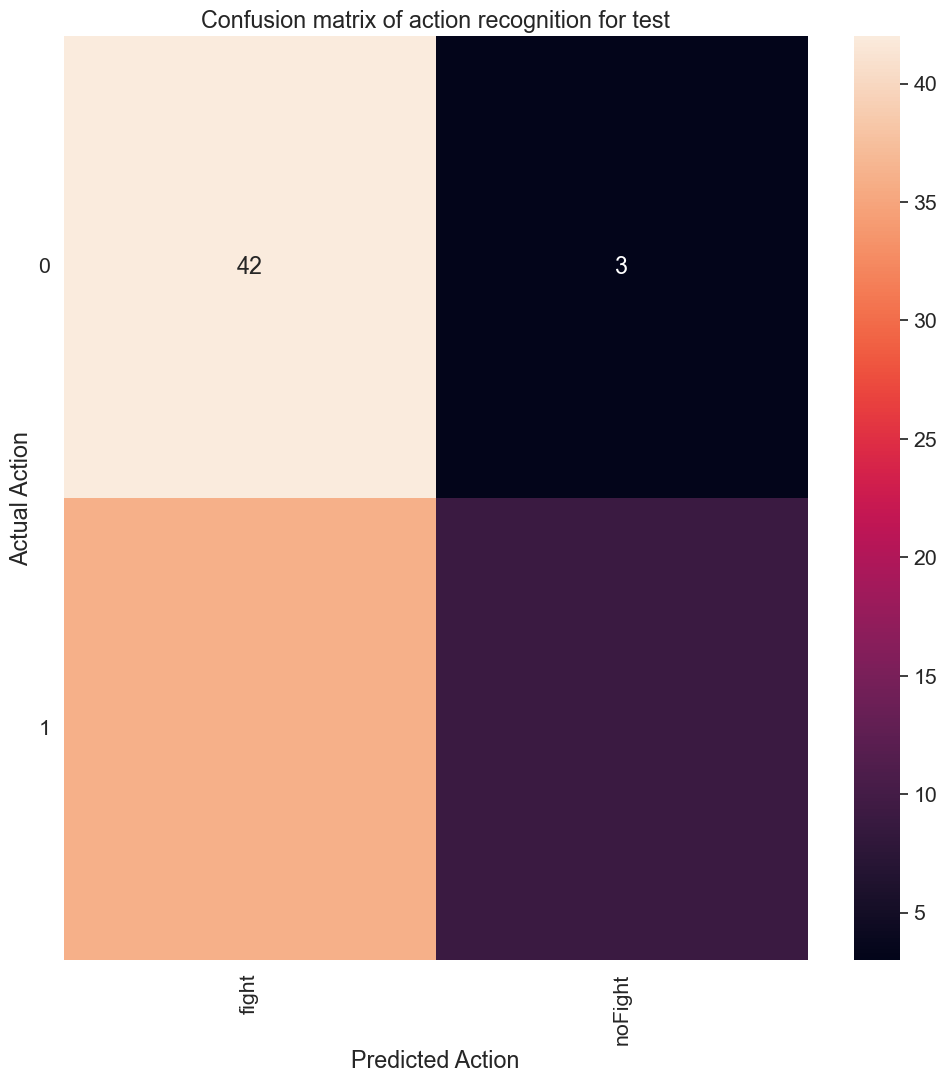

In [88]:
actual, predicted = get_actual_predicted_labels(test_ds)
plot_confusion_matrix(actual, predicted, labels, 'test')

In [89]:
def calculate_classification_metrics(y_actual, y_pred, labels):
  """
    Calculate the precision and recall of a classification model using the ground truth and
    predicted values. 

    Args:
      y_actual: Ground truth labels.
      y_pred: Predicted labels.
      labels: List of classification labels.

    Return:
      Precision and recall measures.
  """
  cm = tf.math.confusion_matrix(y_actual, y_pred)
  tp = np.diag(cm) # Diagonal represents true positives
  precision = dict()
  recall = dict()
  for i in range(len(labels)):
    col = cm[:, i]
    fp = np.sum(col) - tp[i] # Sum of column minus true positive is false negative
    
    row = cm[i, :]
    fn = np.sum(row) - tp[i] # Sum of row minus true positive, is false negative
    
    precision[labels[i]] = tp[i] / (tp[i] + fp) # Precision 
    
    recall[labels[i]] = tp[i] / (tp[i] + fn) # Recall
  
  return precision, recall

In [90]:
precision, recall = calculate_classification_metrics(actual, predicted, labels) # Test dataset

In [91]:
print(precision)

{'fight': 0.5384615384615384, 'noFight': 0.75}


In [92]:
print(recall)

{'fight': 0.9333333333333333, 'noFight': 0.2}


In [36]:
model.summary()

Model: "functional_17"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)      │ (None, 10, 224, 224, 3)   │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv2_plus1d (Conv2Plus1D)    │ (None, 10, 224, 224, 16)  │           3,152 │ input_layer[0][0]          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization           │ (None, 10, 224, 224, 16)  │              64 │ conv2_plus1d[0][0]         │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu (ReLU)                  │ (None, 10, 224, 224, 16)  │               0 │ batch_normalization[0][0]  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resize_video (ResizeVideo)    │ (None, 10, 112, 112, 16)  │               0 │ re_lu[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ residual_main (ResidualMain)  │ (None, 10, 112, 112, 16)  │           6,272 │ resize_video[0][0]         │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add (Add)                     │ (None, 10, 112, 112, 16)  │               0 │ resize_video[0][0],        │
│                               │                           │                 │ residual_main[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resize_video_1 (ResizeVideo)  │ (None, 10, 56, 56, 16)    │               0 │ add[0][0]                  │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ project (Project)             │ (None, 10, 56, 56, 32)    │             608 │ resize_video_1[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ residual_main_1               │ (None, 10, 56, 56, 32)    │          20,224 │ resize_video_1[0][0]       │
│ (ResidualMain)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_1 (Add)                   │ (None, 10, 56, 56, 32)    │               0 │ project[0][0],             │
│                               │                           │                 │ residual_main_1[0][0]      │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ resize_video_2 (ResizeVideo)  │ (None, 10, 28, 28, 32)    │               0 │ add_1[0][0]                │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ project_1 (Project)           │ (None, 10, 28, 28, 64)    │           2,240 │ resize_video_2[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ residual_main_2               │ (None, 10, 28, 28, 64)    │          80,384 │ resize_video_2[0][0]       │
│ (ResidualMain)                │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ add_2 (Add)                   │ (None, 10, 28, 28, 64)    │               

 Total params: 1,326,808 (5.06 MB)

 Trainable params: 442,258 (1.69 MB)

 Non-trainable params: 32 (128.00 B)

 Optimizer params: 884,518 (3.37 MB)

In [37]:
# export model
model.save('complete_saved_model/test2.keras')

In [ ]:
def prepare(video_path, n_frames, output_size = (224, 224), frame_step = 5):
  """
    Creates frames from each video file present for each category.

    Args:
      video_path: File path to the video.
      n_frames: Number of frames to be created per video file.
      output_size: Pixel size of the output frame image.

    Return:
      An NumPy array of frames in the shape of (n_frames, height, width, channels).
  """
  # Read each video frame by frame
  result = []
  src = cv2.VideoCapture(str(video_path))  

  video_length = src.get(cv2.CAP_PROP_FRAME_COUNT)

  need_length = 1 + (n_frames - 1) * frame_step

  if need_length > video_length:
    start = 0
  else:
    max_start = video_length - need_length
    start = random.randint(0, max_start + 1)

  src.set(cv2.CAP_PROP_POS_FRAMES, start)
  # ret is a boolean indicating whether read was successful, frame is the image itself
  ret, frame = src.read()
  result.append(format_frames(frame, output_size))

  for _ in range(n_frames - 1):
    for _ in range(frame_step):
      ret, frame = src.read()
    if ret:
      frame = format_frames(frame, output_size)
      result.append(frame)
    else:
      result.append(np.zeros_like(result[0]))
  src.release()
  result = np.array(result)[..., [2, 1, 0]]

  result = result.reshape((1,) + result.shape)
  return result

In [ ]:
#prediction = model.predict(prepare('./fi125.mp4', 10))

intermediate = prepare('./fightTest.mp4', 10)

prediction = model.predict(intermediate)
predArr = pp.normalize(prediction)
print(np.absolute(predArr))

In [ ]:
intermediate = prepare('./noFightTest.mp4', 10)
print(intermediate.shape)
prediction = model.predict(intermediate)
predArr = pp.normalize(prediction)
print(np.absolute(predArr))